In [2]:
# Generic
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

# Read
from Libs.Management.bank_api import get_current_balance, get_history_balance, get_history_movements

# Write
from Libs.Management.bank_api import update_balance_file, update_movements_file

In [ ]:
import polars as pl
import numpy as np
from Libs.Management.bank_api import get_current_balance, update_balance_file, get_history_balance, get_history_movements, update_movements_file, reconstruct_balance, update_balance_from_movements
get_current_balance()
balance_df = get_history_balance()
movements_df = get_history_movements()
update_movements_file(new_orig_mov_file='data/raw_data/20250604_ListaOperazioni.xlsx')
reconstruct_balance()
update_balance_from_movements()


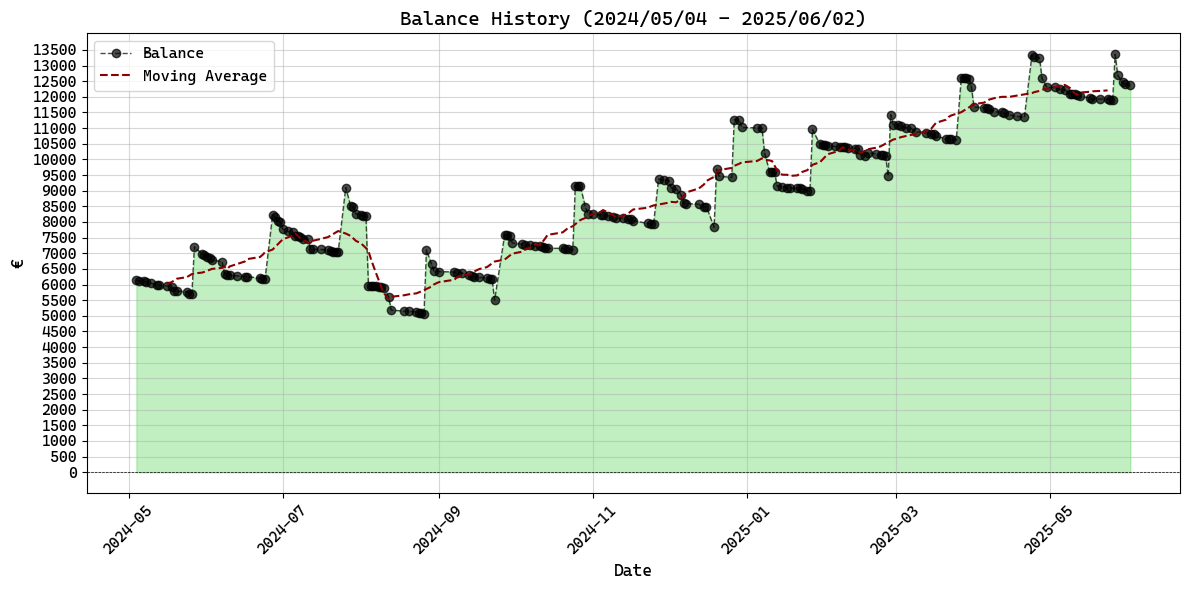

In [ ]:
from Libs.Models.data_visualization import plot_history_movements, plot_history_balance, overlay_generic_graph
from Libs.Management.bank_api import get_current_balance, update_balance_file, get_history_balance, get_history_movements, update_movements_file, reconstruct_balance, update_balance_from_movements
from Libs.Models.data_manipulation import get_regularized_dataset

import polars as pl
import numpy as np

# plot_history_movements()#time_threshold='2025-03-01')
# plot_history_balance()
balance_df = get_history_balance()


def get_moving_average(dataset : pl.DataFrame, window_size=2, regularize=False) -> pl.DataFrame:
    """
    """
    dataset = dataset.with_columns(
        moving_average=pl.col(dataset.columns[-1]).rolling_mean(center=True, window_size=window_size),
    )
    return dataset
df = get_regularized_dataset(balance_df)
df_ma = get_moving_average(df, window_size=15)
plot_history_balance(balance_df=df, additional_plot={'plot_function':overlay_generic_graph, 'plot_parameters':{'dataset':df_ma, 'col_to_plot':'moving_average',
                                                                                                            'color':'darkred', 'linestyle':'--','label':'Moving Average'}})
